# 2.Image Processing 

In [ ]:
## Importing packages
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from random import sample
import seaborn as sns

In [ ]:
# Define the directory where your images are located
image_dir = '/content/drive/MyDrive/October 2023/classificationandtemperature_xlsx/Photos_2'

# Load the Excel data
data = pd.read_excel('/content/drive/MyDrive/October 2023/classificationandtemperature_xlsx/Classification and temperature.xlsx')
print('Number of records in the file:', data.shape[0])
print('Number of attributes in the file:', data.shape[1])

Number of records in the file: 64
Number of attributes in the file: 13


In [ ]:
# Convert values in PAD and Neuropathy to lowercase

data['PAD'] = data['PAD'].apply(lambda x: x.lower())
data['Neuropathy'] = data['Neuropathy'].apply(lambda x: x.lower())

# Preprocess and clean the data, encode target variables
data['PAD'] = data['PAD'].map({'yes': 1, 'no': 0})
data['Neuropathy'] = data['Neuropathy'].map({'yes': 1, 'no': 0})

# Display the updated DataFrame
data[['PAD', 'Neuropathy']].head()

PAD  Neuropathy
0    0           0
1    0           0
2    0           0
3    0           0
4    0           0

In [ ]:
# Seeing the "2nd digit" column for "9 left" subject to be "amputation". Converting it to 0

# Before conversion:
print(data.iloc[17,4])

# Convert:
data.iloc[17, 4] = 0

# After conversion:
print(data.iloc[17,4])

amputation
0


In [ ]:
# Initialize lists to store image data and labels
X = []
y_pad = []
y_neuropathy = []

In [ ]:
# Load and preprocess images, extract features, and create feature matrix
for i in range(1, 33):
  left_image = cv2.imread(os.path.join(image_dir, f'Subject {i}.jpg'))
  right_image = cv2.imread(os.path.join(image_dir, f'Subject {i + 32}.jpg'))
  left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
  right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
  left_image = cv2.resize(left_image, (224, 224))  # Resize images as needed
  right_image = cv2.resize(right_image, (224, 224))
  X.append(right_image)
  X.append(left_image)
  y_pad.append(data.iloc[i + 31]['PAD'])  # Left foot PAD
  y_neuropathy.append(data.iloc[i + 31]['Neuropathy'])  # Left foot Neuropathy
  y_pad.append(data.iloc[i - 1]['PAD'])  # Right foot PAD
  y_neuropathy.append(data.iloc[i - 1]['Neuropathy'])  # Right foot Neuropathy

X = np.array(X)
y_pad = np.array(y_pad)
y_neuropathy = np.array(y_neuropathy)

print('Shape of X:', X.shape)
print('Shape of y pad:', y_pad.shape)
print('Shape of y neuropathy:', y_neuropathy.shape)

Shape of X: (64, 224, 224, 3)
Shape of y pad: (64,)
Shape of y neuropathy: (64,)


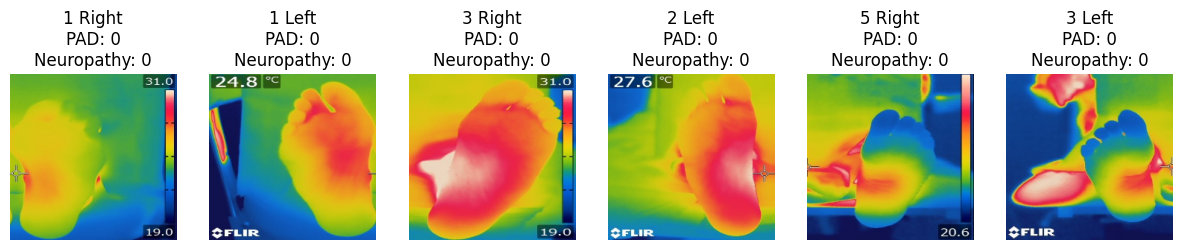

In [ ]:
# Display the first 5 subject images
plt.figure(figsize=(15, 5))
for i in range(6):
  plt.subplot(1, 6, i + 1)
  plt.imshow(X[i])
  if i%2 == 1:
    plt.title(f"{data.iloc[i]['Subject Number']}\nPAD: {data.iloc[i]['PAD']}\nNeuropathy: {data.iloc[i]['Neuropathy']}")
  else:
    plt.title(f"{i + 1} Right\nPAD: {data.iloc[i]['PAD']}\nNeuropathy: {data.iloc[i]['Neuropathy']}")
  plt.axis('off')
plt.show()

In [ ]:
# Split the data into training and testing sets for PAD and Neuropathy
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X, y_pad, test_size=0.3, random_state=42)
X_train_neuropathy, X_test_neuropathy, y_train_neuropathy, y_test_neuropathy = train_test_split(X, y_neuropathy, test_size=0.3, random_state=42)

In [ ]:
def plot_confusion_matrix(ytest, ypred, title, pad_neuropathy):
  # Confusion matrix plot
  cm = confusion_matrix(ytest, ypred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title(f'{title}: Confusion Matrix')

  # 0 = no pad or no neuropathy, 1 = have pad or neuropathy
  if pad_neuropathy == 'pad':
    ax.xaxis.set_ticklabels(['No PAD = 0', 'PAD = 1'])
    ax.yaxis.set_ticklabels(['No PAD = 0', 'PAD = 1'])
  else:
    ax.xaxis.set_ticklabels(['No Neuropathy = 0', 'Neuropathy = 1'])
    ax.yaxis.set_ticklabels(['No Neuropathy = 0', 'Neuropathy = 1'])

  plt.show()

def plot_roc(fpr, tpr, model, auc):
  # Plot ROC curves
  plt.figure(figsize=(5, 5))

  # Plot ROC curve
  plt.plot(fpr, tpr, label=f'{model} (AUC = {auc:.2f})')

  # Plot guessing line
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

  # Setting plot labels and title
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title(f'ROC Curve: {model}')
  plt.legend(loc='lower right')

  # Show the plot
  plt.show()

### PAD prediction

In [ ]:
# SVM Classifier - PAD
svm_classifier_pad = SVC(probability=True, random_state=42)
svm_classifier_pad.fit(X_train_pad.reshape(-1, 224 * 224 * 3), y_train_pad)

# Random Forest Classifier - PAD
rf_classifier_pad = RandomForestClassifier(random_state=42)
rf_classifier_pad.fit(X_train_pad.reshape(-1, 224 * 224 * 3), y_train_pad)

# CNN Model - PAD
model_pad = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_pad.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_pad.fit(X_train_pad, y_train_pad, epochs=10, batch_size=16)

Epoch 1/10
3/3 [==============================] - 5s 801ms/step - loss: 8756.8799 - accuracy: 0.3864
Epoch 2/10
3/3 [==============================] - 2s 809ms/step - loss: 3037.5674 - accuracy: 0.7045
Epoch 3/10
3/3 [==============================] - 2s 729ms/step - loss: 2723.9287 - accuracy: 0.7045
Epoch 4/10
3/3 [==============================] - 2s 754ms/step - loss: 593.2536 - accuracy: 0.6136
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 164.7485 - accuracy: 0.5227
Epoch 6/10
3/3 [==============================] - 3s 869ms/step - loss: 27.6975 - accuracy: 0.8636
Epoch 7/10
3/3 [==============================] - 2s 632ms/step - loss: 62.3236 - accuracy: 0.7045
Epoch 8/10
3/3 [==============================] - 1s 419ms/step - loss: 5.6274 - accuracy: 0.9318
Epoch 9/10
3/3 [==============================] - 1s 413ms/step - loss: 11.4719 - accuracy: 0.8864
Epoch 10/10
3/3 [==============================] - 1s 425ms/step - loss: 14.0485 - accuracy: 0.8636


SVM accuracy in predicting PAD:  0.65
SVM F1-score in predicting PAD:  0.0


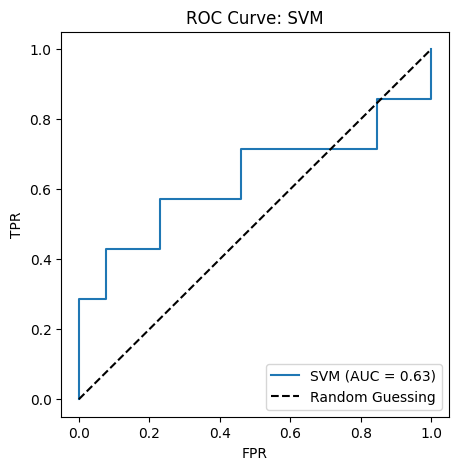

Random Forest accuracy in predicting PAD:  0.65
Random Forest F1-score in predicting PAD:  0.36363636363636365


1/1 [==============================] - 0s 254ms/step - loss: 65.5010 - accuracy: 0.7500
Test Loss: 65.50102233886719
Test Accuracy: 0.75
1/1 [==============================] - 0s 202ms/step


In [ ]:
# Make predictions on the testing set
svm_predictions_pad = svm_classifier_pad.predict(X_test_pad.reshape(-1, 224 * 224 * 3))
rf_predictions_pad = rf_classifier_pad.predict(X_test_pad.reshape(-1, 224 * 224 * 3))

# Calculate classification metrics
svm_accuracy = accuracy_score(y_test_pad, svm_predictions_pad)
svm_f1 = f1_score(y_test_pad, svm_predictions_pad)
svm_probabilities = svm_classifier_pad.predict_proba(X_test_pad.reshape(-1, 224 * 224 * 3))[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_pad, svm_probabilities)
svm_auc = roc_auc_score(y_test_pad, svm_probabilities)
print('SVM accuracy in predicting PAD: ', svm_accuracy)
print('SVM F1-score in predicting PAD: ', svm_f1)
plot_confusion_matrix(y_test_pad, svm_predictions_pad, 'SVM', 'pad')
plot_roc(svm_fpr, svm_tpr, 'SVM', svm_auc)


rf_accuracy = accuracy_score(y_test_pad, rf_predictions_pad)
rf_f1 = f1_score(y_test_pad, rf_predictions_pad)
rf_probabilities = rf_classifier_pad.predict_proba(X_test_pad.reshape(-1, 224 * 224 * 3))[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test_pad, rf_probabilities)
rf_auc = roc_auc_score(y_test_pad, rf_probabilities)
print('Random Forest accuracy in predicting PAD: ', rf_accuracy)
print('Random Forest F1-score in predicting PAD: ', rf_f1)
plot_confusion_matrix(y_test_pad, rf_predictions_pad, 'Random Forest', 'pad')
plot_roc(rf_fpr, rf_tpr, 'Random Forest', rf_auc)


# Evaluate the model on the test set
test_loss, test_accuracy = model_pad.evaluate(X_test_pad, y_test_pad)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
cnn_predictions_pad_encode = model_pad.predict(X_test_pad)
cnn_predictions_pad = np.argmax(cnn_predictions_pad_encode, axis=1)
cnn_fpr, cnn_tpr, thresholds = roc_curve(y_test_pad, cnn_predictions_pad_encode)
cnn_auc = roc_auc_score(y_test_pad, cnn_predictions_pad_encode)
plot_confusion_matrix(y_test_pad, cnn_predictions_pad, 'CNN', 'pad')
plot_roc(cnn_fpr, cnn_tpr, 'CNN', cnn_auc)

### Neuropathy prediction

In [ ]:
# SVM Classifier - Neuropathy
svm_classifier_neuropathy = SVC(probability=True, random_state=42)
svm_classifier_neuropathy.fit(X_train_neuropathy.reshape(-1, 224 * 224 * 3), y_train_neuropathy)

# Random Forest Classifier - neuropathy
rf_classifier_neuropathy = RandomForestClassifier(random_state=42)
rf_classifier_neuropathy.fit(X_train_neuropathy.reshape(-1, 224 * 224 * 3), y_train_neuropathy)

# CNN Model - neuropathy
model_neuropathy = keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_neuropathy.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_neuropathy.fit(X_train_neuropathy, y_train_neuropathy, epochs=10, batch_size=16)

Epoch 1/10
3/3 [==============================] - 2s 423ms/step - loss: 6377.1875 - accuracy: 0.4318
Epoch 2/10
3/3 [==============================] - 1s 418ms/step - loss: 2585.8418 - accuracy: 0.7955
Epoch 3/10
3/3 [==============================] - 1s 413ms/step - loss: 2581.7087 - accuracy: 0.7955
Epoch 4/10
3/3 [==============================] - 1s 408ms/step - loss: 1633.4187 - accuracy: 0.7955
Epoch 5/10
3/3 [==============================] - 2s 633ms/step - loss: 405.4702 - accuracy: 0.7955
Epoch 6/10
3/3 [==============================] - 2s 610ms/step - loss: 2.3784 - accuracy: 0.6364
Epoch 7/10
3/3 [==============================] - 2s 578ms/step - loss: 0.6936 - accuracy: 0.2045
Epoch 8/10
3/3 [==============================] - 1s 405ms/step - loss: 0.6935 - accuracy: 0.2045
Epoch 9/10
3/3 [==============================] - 1s 405ms/step - loss: 0.6932 - accuracy: 0.4318
Epoch 10/10
3/3 [==============================] - 1s 400ms/step - loss: 0.6928 - accuracy: 0.7955


SVM accuracy in predicting neuropathy:  0.6
SVM F1-score in predicting neuropathy:  0.0


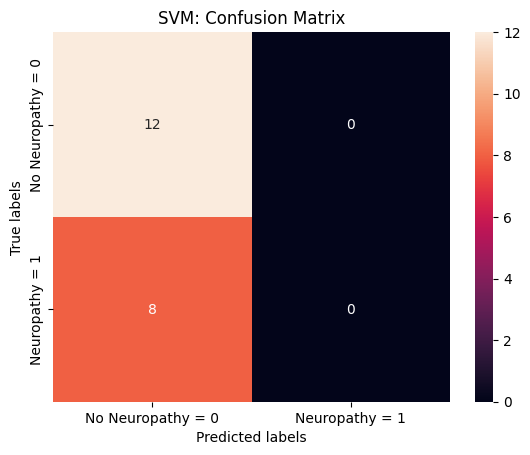

Random Forest accuracy in predicting neuropathy:  0.6
Random Forest F1-score in predicting neuropathy:  0.0


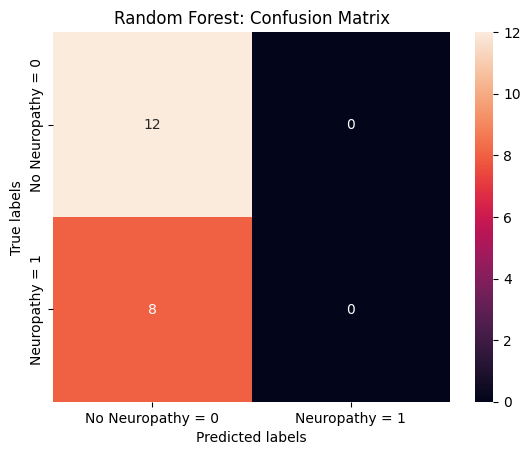

1/1 [==============================] - 0s 344ms/step - loss: 0.6929 - accuracy: 0.6000
Test Loss: 0.6928901672363281
Test Accuracy: 0.6000000238418579
1/1 [==============================] - 0s 269ms/step


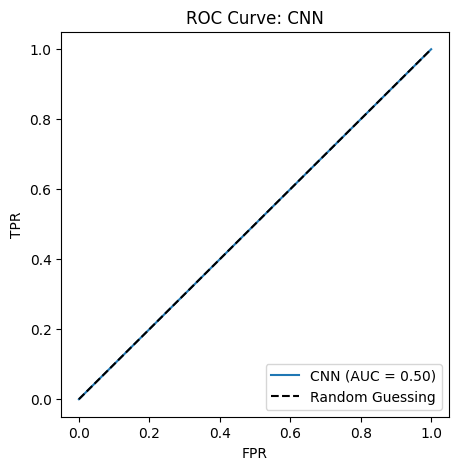

In [ ]:
# Make predictions on the testing set
svm_predictions_neuropathy = svm_classifier_neuropathy.predict(X_test_neuropathy.reshape(-1, 224 * 224 * 3))
rf_predictions_neuropathy = rf_classifier_neuropathy.predict(X_test_neuropathy.reshape(-1, 224 * 224 * 3))

# Calculate classification metrics
svm_accuracy = accuracy_score(y_test_neuropathy, svm_predictions_neuropathy)
svm_f1 = f1_score(y_test_neuropathy, svm_predictions_neuropathy)
svm_probabilities = svm_classifier_neuropathy.predict_proba(X_test_neuropathy.reshape(-1, 224 * 224 * 3))[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test_neuropathy, svm_probabilities)
svm_auc = roc_auc_score(y_test_neuropathy, svm_probabilities)
print('SVM accuracy in predicting neuropathy: ', svm_accuracy)
print('SVM F1-score in predicting neuropathy: ', svm_f1)
plot_confusion_matrix(y_test_neuropathy, svm_predictions_neuropathy, 'SVM', 'neuropathy')
plot_roc(svm_fpr, svm_tpr, 'SVM', svm_auc)


rf_accuracy = accuracy_score(y_test_neuropathy, rf_predictions_neuropathy)
rf_f1 = f1_score(y_test_neuropathy, rf_predictions_neuropathy)
rf_probabilities = rf_classifier_neuropathy.predict_proba(X_test_neuropathy.reshape(-1, 224 * 224 * 3))[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test_neuropathy, rf_probabilities)
rf_auc = roc_auc_score(y_test_neuropathy, rf_probabilities)
print('Random Forest accuracy in predicting neuropathy: ', rf_accuracy)
print('Random Forest F1-score in predicting neuropathy: ', rf_f1)
plot_confusion_matrix(y_test_neuropathy, rf_predictions_neuropathy, 'Random Forest', 'neuropathy')
plot_roc(rf_fpr, rf_tpr, 'Random Forest', rf_auc)


# Evaluate the model on the test set
test_loss, test_accuracy = model_neuropathy.evaluate(X_test_neuropathy, y_test_neuropathy)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
cnn_predictions_neuropathy_encode = model_neuropathy.predict(X_test_neuropathy)
cnn_predictions_neuropathy = np.argmax(cnn_predictions_neuropathy_encode, axis=1)
cnn_fpr, cnn_tpr, thresholds = roc_curve(y_test_neuropathy, cnn_predictions_neuropathy_encode)
cnn_auc = roc_auc_score(y_test_neuropathy, cnn_predictions_neuropathy_encode)
plot_confusion_matrix(y_test_neuropathy, cnn_predictions_neuropathy, 'CNN', 'neuropathy')
plot_roc(cnn_fpr, cnn_tpr, 'CNN', cnn_auc)

### Actual vs Predicted images

In [ ]:
# Reshape arrays to have shape (20, 1)
svm_predictions_pad = svm_predictions_pad.reshape(-1, 1)
rf_predictions_pad = rf_predictions_pad.reshape(-1, 1)
cnn_predictions_pad = cnn_predictions_pad.reshape(-1, 1)


svm_predictions_neuropathy = svm_predictions_neuropathy.reshape(-1,1)
rf_predictions_neuropathy = rf_predictions_neuropathy.reshape(-1,1)
cnn_predictions_neuropathy = cnn_predictions_neuropathy.reshape(-1,1)

# Append the reshaped arrays along the second axis to get shape (20, 2)
svm_predictions = np.append(svm_predictions_pad, svm_predictions_neuropathy, axis=1)
rf_predictions = np.append(rf_predictions_pad, rf_predictions_neuropathy, axis=1)
cnn_predictions = np.append(cnn_predictions_pad, cnn_predictions_neuropathy, axis=1)

print(svm_predictions.shape, rf_predictions.shape, cnn_predictions.shape)

(20, 2) (20, 2) (20, 2)


In [ ]:
# Display a sample of 5 predicted images with their actual and predicted values - SVM
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
sample_indices = np.random.choice(len(X_test_pad), 5, replace=False)
for i, index in enumerate(sample_indices):
    image = X_test_pad[index]
    actual_pad = y_test_pad[index]
    actual_neuropathy = y_test_neuropathy[index]
    predicted_pad = svm_predictions_pad[index]
    predicted_neuropathy = svm_predictions_neuropathy[index]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{data.iloc[index]['Subject Number']}\nActual: PAD - {actual_pad}; Neuropathy - {actual_neuropathy}\nPred: PAD - {predicted_pad}; Neuropathy - {predicted_neuropathy}")
plt.tight_layout()
plt.show()

In [ ]:
# Display a sample of 5 predicted images with their actual and predicted values - RF
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
sample_indices = np.random.choice(len(X_test_pad), 5, replace=False)
for i, index in enumerate(sample_indices):
    image = X_test_pad[index]
    actual_pad = y_test_pad[index]
    actual_neuropathy = y_test_neuropathy[index]
    predicted_pad = rf_predictions_pad[index]
    predicted_neuropathy = rf_predictions_neuropathy[index]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{data.iloc[index]['Subject Number']}\nActual: PAD - {actual_pad}; Neuropathy - {actual_neuropathy}\nPred: PAD - {predicted_pad}; Neuropathy - {predicted_neuropathy}")
plt.tight_layout()
plt.show()

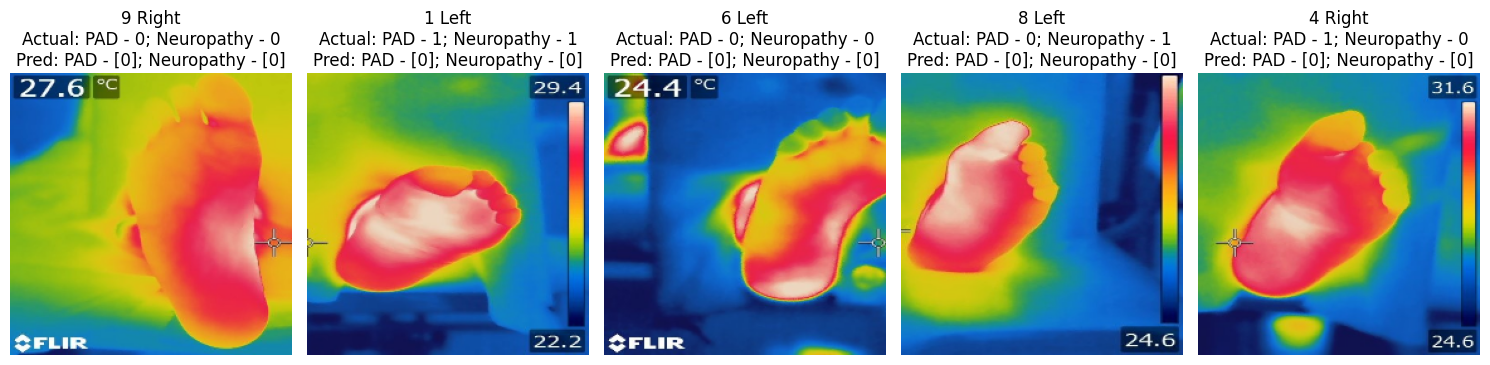

In [ ]:
# Display a sample of 5 predicted images with their actual and predicted values - CNN
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
sample_indices = np.random.choice(len(X_test_pad), 5, replace=False)
for i, index in enumerate(sample_indices):
    image = X_test_pad[index]
    actual_pad = y_test_pad[index]
    actual_neuropathy = y_test_neuropathy[index]
    predicted_pad = cnn_predictions_pad[index]
    predicted_neuropathy = cnn_predictions_neuropathy[index]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{data.iloc[index]['Subject Number']}\nActual: PAD - {actual_pad}; Neuropathy - {actual_neuropathy}\nPred: PAD - {predicted_pad}; Neuropathy - {predicted_neuropathy}")
plt.tight_layout()
plt.show()